In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
network = tf.keras.applications.VGG19(include_top=False, weights="imagenet")

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
network.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

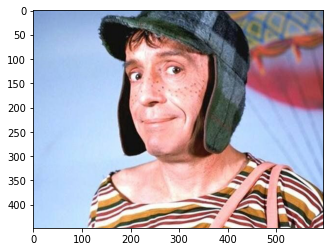

In [ ]:
content_image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/Data science/Images/chaves.jpeg")
plt.imshow(content_image)

In [ ]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)

In [ ]:
content_image.shape

(448, 598, 3)

In [ ]:
content_image = content_image / 255

In [ ]:
content_image = content_image[tf.newaxis, :]

In [ ]:
content_image.shape

(1, 448, 598, 3)

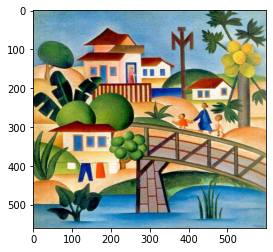

In [ ]:
style_image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/Data science/Computer Vision Masterclass/Images/tarsila_amaral.jpg")
plt.imshow(style_image)

In [ ]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]
style_image.shape

(1, 560, 600, 3)

In [ ]:
content_layers = ["block4_conv2"]
style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top = False, weights ="imagenet")
  vgg.trainable = False

  outputs  = [vgg.get_layer(name).output for name in layer_names]
  network = tf.keras.Model(inputs = [vgg.input], outputs = outputs)

  return network

In [ ]:
style_extractor = vgg_layers(style_layers)

In [ ]:
style_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
content_extractor = vgg_layers(content_layers)
content_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [ ]:
style_extractor.outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [ ]:
content_extractor.outputs

[<KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv2')>]

In [ ]:
style_outputs = style_extractor(style_image)

In [ ]:
shapes = [style_outputs[i].shape for i in range(len(style_outputs))]

In [ ]:
shapes

[TensorShape([1, 560, 600, 64]),
 TensorShape([1, 280, 300, 128]),
 TensorShape([1, 140, 150, 256]),
 TensorShape([1, 70, 75, 512]),
 TensorShape([1, 35, 37, 512])]

In [ ]:
def gram_matrix(layer_activation):
  result = tf.linalg.einsum('bijc, bijd->bcd', layer_activation, layer_activation)
  input_shape = tf.shape(layer_activation)
  num_locations = tf.cast(input_shape[1] * input_shape[1], tf.float32)

  return result / num_locations

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super().__init__()  # this calls the constructor of Model class that initializes the object
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg_trainable = False

  def call(self, inputs):
    inputs = inputs *255.0 #denormalize the image
    preprocessed_inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_inputs)
    style_outputs = outputs[:self.num_style_layers]
    content_outputs = outputs[self.num_style_layers:]

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {"content": content_dict, "style": style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

In [ ]:
results = extractor(content_image)

In [ ]:
results

{'content': {'block4_conv2': <tf.Tensor: shape=(1, 56, 74, 512), dtype=float32, numpy=
  array([[[[  17.105906,    0.      ,    0.      , ...,  574.59753 ,
               0.      ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,  291.4188  ,
             132.35075 ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,  332.0522  ,
             118.95296 ,    0.      ],
           ...,
           [ 700.1252  ,    0.      ,    0.      , ..., 1511.4626  ,
              11.20654 ,  325.48343 ],
           [ 141.8678  ,    0.      ,    0.      , ..., 1099.7535  ,
              96.57425 ,  195.72565 ],
           [ 137.43658 ,    0.      ,    0.      , ...,  469.20248 ,
             180.22122 ,  676.2001  ]],
  
          [[   0.      ,    0.      ,    0.      , ...,  549.1022  ,
               0.      ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,   44.160194,
               0.      ,    0.      ],
           [   0.      ,    0

In [ ]:
for key,value in results.items():
  print(key, value.keys())

content dict_keys(['block4_conv2'])
style dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
new_image = tf.Variable(content_image)

In [ ]:
content_weight = 1
style_weight = 1000

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate = 0.02)

Epochs: 5001, content_loss: 533402.4375, style_loss: 168990816.0, total loss: 33798696960.0


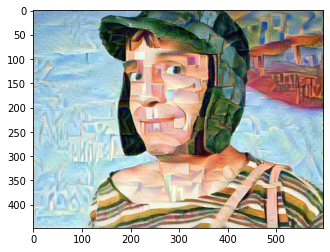

Epochs: 5001, content_loss: 554056.125, style_loss: 316629312.0, total loss: 63326416896.0


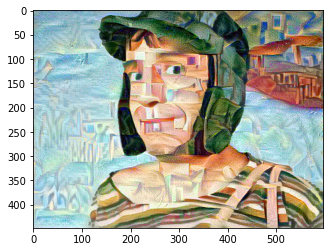

Epochs: 5001, content_loss: 576850.125, style_loss: 114932840.0, total loss: 22987145216.0


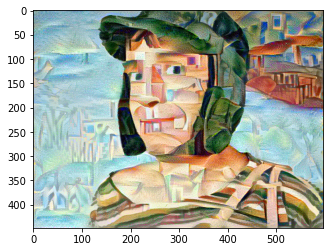

Epochs: 5001, content_loss: 585153.9375, style_loss: 531115744.0, total loss: 106223730688.0


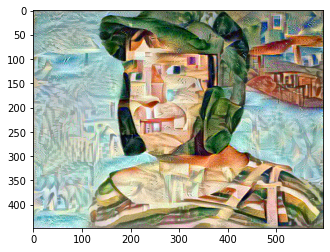

Epochs: 5001, content_loss: 598451.375, style_loss: 470688864.0, total loss: 94138368000.0


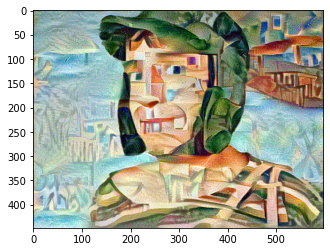

Epochs: 5001, content_loss: 608018.5625, style_loss: 197258336.0, total loss: 39452270592.0


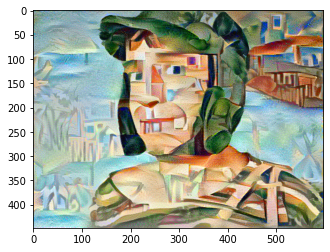

Epochs: 5001, content_loss: 616066.0625, style_loss: 118599088.0, total loss: 23720433664.0


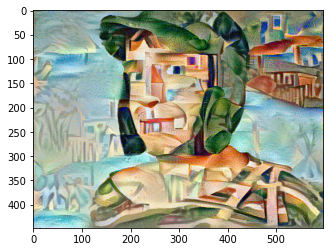

Epochs: 5001, content_loss: 624108.5625, style_loss: 67093132.0, total loss: 13419249664.0


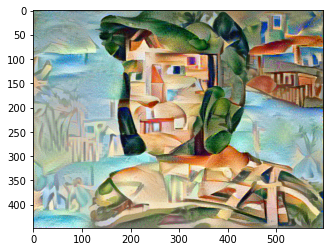

Epochs: 5001, content_loss: 634226.9375, style_loss: 103095472.0, total loss: 20619728896.0


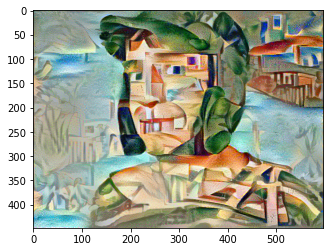

Epochs: 5001, content_loss: 637058.6875, style_loss: 95732528.0, total loss: 19147143168.0


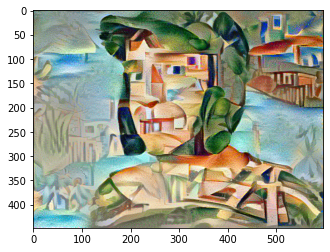

In [ ]:
epochs = 5000
print_after_epochs = 500

for epoch in range(epochs + 1):
  with tf.GradientTape() as tape:
    outputs = extractor(new_image)

    content_outputs = outputs['content']
    style_outputs = outputs['style']

    content_loss = tf.add_n([tf.math.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    style_loss = tf.add_n([tf.math.reduce_mean((style_outputs[name] - style_targets[name])** 2) for name in style_outputs.keys()])

    total_loss = content_loss * content_weight / len(content_layers) + style_loss * style_weight / len(style_layers)
  gradient = tape.gradient(total_loss, new_image)
  optimizer.apply_gradients([(gradient, new_image)])
  new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

  if (epoch + 1) % print_after_epochs == 0:
    print("Epochs: {}, content_loss: {}, style_loss: {}, total loss: {}" .format((epoch+1), content_loss, style_loss, total_loss))
    plt.imshow(tf.squeeze(new_image, axis = 0))  #to remove the first extrs added dimension
    plt.show()


(-0.5, 599.5, 559.5, -0.5)

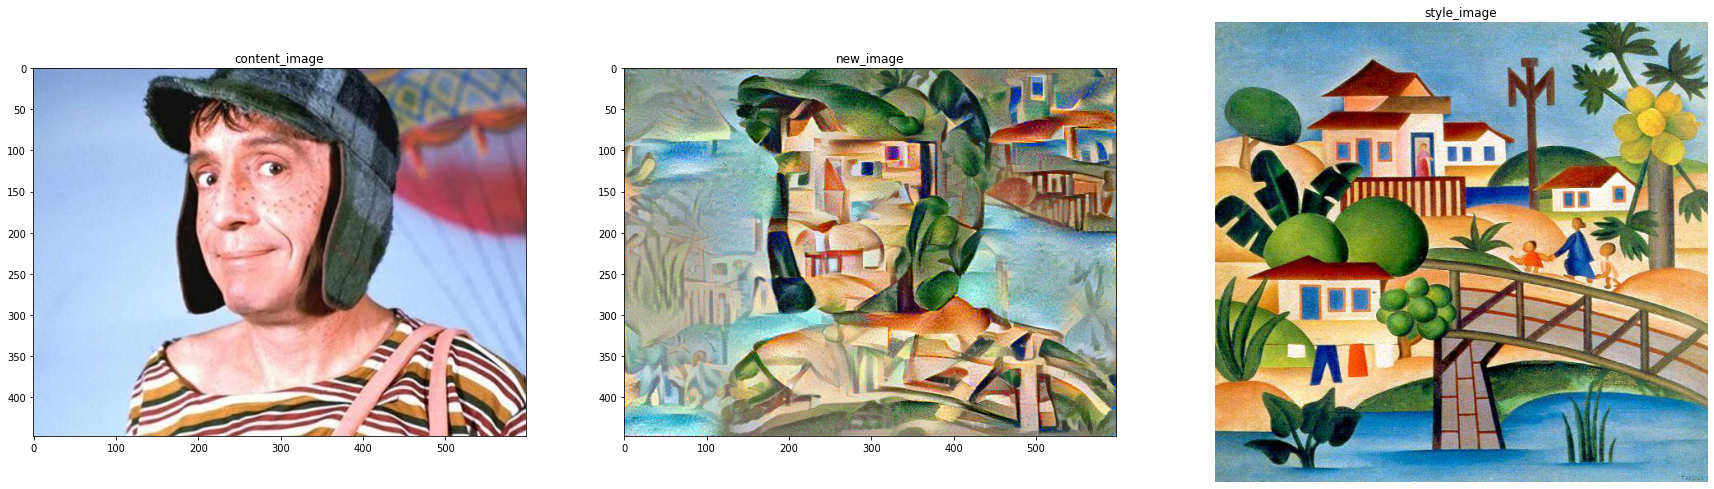

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (30, 10))
ax[0].imshow(tf.squeeze(content_image, axis = 0))
ax[0].set_title("content_image")
plt.axis("off")
ax[1].imshow(tf.squeeze(new_image, axis = 0))
ax[1].set_title("new_image")
plt.axis("off")
ax[2].imshow(tf.squeeze(style_image, axis = 0))
ax[2].set_title("style_image")
plt.axis("off")